# importing functions

In [4]:
import random
from itertools import count
from matplotlib.animation import FuncAnimation
import time
import matplotlib.pyplot as plt
import follow_road

%run localisation.ipynb
%run follow_road.py

In [5]:
# Import tdmclient Notebook environment:
import tdmclient.notebook

In [6]:
await tdmclient.notebook.start()

# Graphical functions

In [57]:
def draw_trajectory(traj) :
    #fig=plt.figure()
    #ax1=fig.add_subplot(111)
    #ax2=fig.add_subplot(221)
    xs, ys = zip(*traj)
    plt.plot(xs,ys)
    #ax1.set_aspect('equal')
    return

Unchecked Starred(value=Name(id='traj', ctx=Load()), ctx=Load())


In [58]:
def draw_thymio(pose) :
    move=pose[0:2]
    angle=pose[2]-math.pi/2
    thymio_shape=[[-0.5,-0.5],[0.5,-0.5],[0.5,0.25],[0,0.75],[-0.5,0.25]]
    
    thymio_shape.append(thymio_shape[0]) #repeat the first point to create a 'closed loop'
    rot=np.array([[np.cos(angle) , -np.sin(angle)],[np.sin(angle),np.cos(angle)]])
    thymio_shape=(np.transpose((np.matmul(rot,np.transpose(100*np.array(thymio_shape))))))
    thymio_shape+=[move,move,move,move,move,move]
    xs, ys = zip(*thymio_shape) #create lists of x and y values
    fig=plt.figure(figsize=(8, 8), dpi=80)

    ax = fig.add_subplot(111)
    ax.set_aspect('equal')

    plt.xlim((0,1600))
    plt.ylim((0,1100))
    plt.plot(xs,ys)
    return thymio_shape

Unchecked Starred(value=Name(id='thymio_shape', ctx=Load()), ctx=Load())


In [59]:
def draw_now(pose,traj) :
    draw_thymio(pose)
    draw_trajectory(traj)
    plt.show()
    return


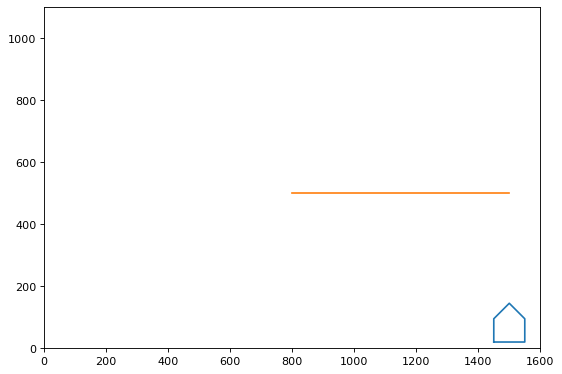

In [60]:
draw_now(S,trajnp)

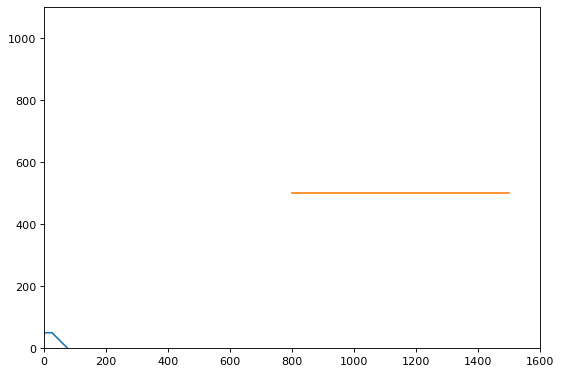

array([[-5.0000000e+01,  5.0000000e+01],
       [-5.0000000e+01, -5.0000000e+01],
       [ 2.5000000e+01, -5.0000000e+01],
       [ 7.5000000e+01,  4.5924255e-15],
       [ 2.5000000e+01,  5.0000000e+01],
       [-5.0000000e+01,  5.0000000e+01]])

In [61]:
thymio_shape=draw_thymio([0,0,0])
draw_trajectory(trajnp)
plt.show()
thymio_shape

# stop and turn approach

In [17]:
def inverse_kin(pose,obj) :
    global motor_left_target, motor_right_target
    angle_thres=math.pi/12
    angle=theta_des(pose,obj)
    error=angle-pose[2]
    if error>math.pi : 
        error-=2*math.pi
    if error< -(math.pi) :
        error+=2*math.pi
    speed=200
    coeff=100*5/math.pi # experimental value : half a turn with speed=100 takes 5 seconds
    t=abs(error)/speed*coeff
    
    vl=-np.sign(error)*speed
    vr=-vl
    motor_left_target = int(vl)
    motor_right_target = int(vr)
    
    time.sleep(2.5)
    
    motor_left_target = 0
    motor_right_target = 0
    return [vl,vr,t]
    

[-200.0, 200.0, 1.2500000000000002]


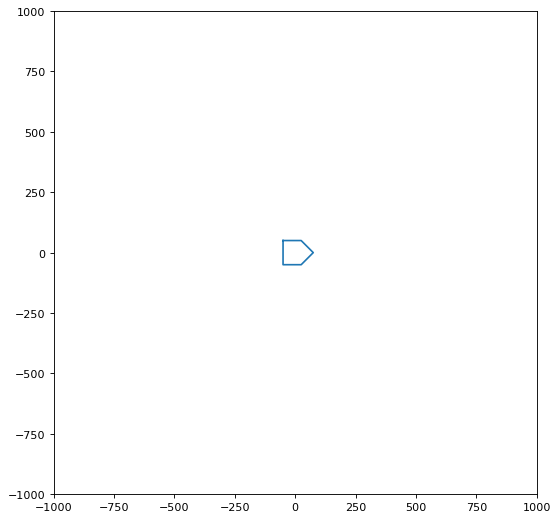

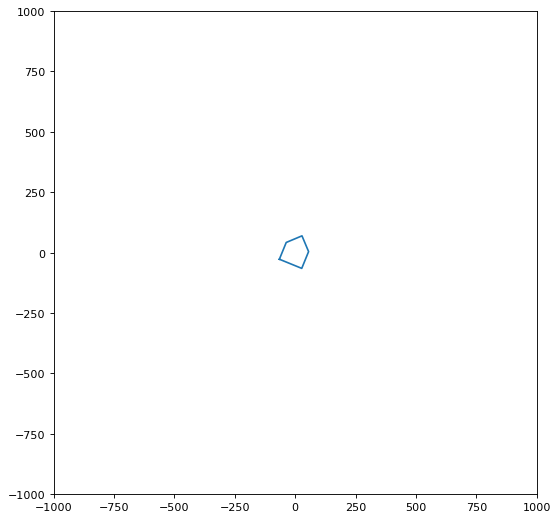

In [18]:
pose=[0,0,0]
draw_thymio(pose)
vl=vr=0
next_point=[0,500]

[vl,vr,dt]=inverse_kin(pose,next_point)
pose=kinematics2(pose,vl,vr,dt*1000)
draw_thymio(pose)
print([vl,vr,dt])

In [20]:
motor_left_target = int(vl)
motor_right_target = int(vr)
sleep(dt)
    
motor_left_target = 300
motor_right_target = 300
sleep(2)
motor_left_target = 0
motor_right_target = 0

In [21]:
t=float(0.5)
if 1 :
    motor_left_target = -100
    motor_right_target = 100
sleep(t)
motor_left_target = 100
motor_right_target = -100
sleep(t)
motor_left_target = 0
motor_right_target = 0

In [22]:
motor_left_target = 0
motor_right_target = 0

# PID controller

In [33]:
traj[0]
trajnp=np.array([[800,500],[1500,500]])
trajnp

array([[ 800,  500],
       [1500,  500]])

In [111]:
def PID(e,ediff,eint) :

    Kp=12
    Ki=0.05
    Kd=0
    correction=Kp*e+Ki*eint+Kd*ediff
    return correction

def theta_des(pos,obj) :
    '''
    orientation desired to face towards the goal
    
    '''
    return math.atan2(obj[1]-pos[1],obj[0]-pos[0])

def speed_des(pos,obj) :
    '''
    straight line speed desired, constant component + variable 
    component depending on distance to next point
    '''
    vbase=500
    coeff=0.5 # weight of variable component
    return vbase+coeff*math.sqrt((obj[1]-pos[1])**2+(obj[0]-pos[0])**2)

def wheel_inputs(omega,v) :
    '''
    calculates the motor speeds for the robot
    
    Arguments:
        - omega: correction, output of the PID
        - v: desired straight line speed
    Outputs:
        - [vl,vr]: left and right motor speeds 
    
    '''
    R=20 #wheel radius in [mm]
    L=95 #distance between wheels in [mm]
    vl=5*(2*v-omega*L)/(2*R) #left motor speed
    vr=5*(2*v+omega*L)/(2*R) #right motor speed
    
    #### setting lower and upper bounds ####
    if vr<0 :
        vr=max(-300,vr)
    else :
        vr=min(300,vr)
        
    if vl<0 :
        vl=max(-300,vl)
    else :
        vl=min(300,vl)

    
    return [int(vl),int(vr)]

def compute_error(pose,obj) : 
    angle=theta_des(pose,obj)
    error=angle-pose[2]
    if error>math.pi : 
        error-=2*math.pi
    if error< -(math.pi) :
        error+=2*math.pi
    return error

In [112]:
def follow_path(pose,trajectory,graph) :
    # following the path
    # initialisation 
    dt=0.1 # control period in [s]
    
    myPose=Pose(pose[0],pose[1],pose[2])
    
    nx_pt_id=0 # index of the next point to attain in the trajectory, set as 0 to start
    next_point=trajnp[nx_pt_id]
    
    prev_error=0 
    e_int=0
    
    distance_to_goal=dist(pose,trajnp[-1])
    
    iter=0

    while not(distance_to_goal < 5 and nx_pt_id==len(trajnp)-1) : # main control loop
        
        ########     get position    #######
        global prox_ground_delta, motor_left_target, motor_right_target, motor_left_speed, motor_right_speed
        #pose=kinematics2(pose,vl,vr,dt)
        myPose.update([motor_left_speed,motor_right_speed],prox_ground_delta,dt,myMap)
        pose=list(myPose.get_coords().values()) #pose in list form for low level functions
        #angle=theta_des(pose,next_point)
        v=speed_des(pose,next_point) 
        
        
        ########    call pid   ##########
        error=compute_error(pose,next_point)
        e_diff=(error-prev_error)/dt
        e_int+=error
        omega=PID(error,e_diff,e_int)

        #######  set wheel speeds    #######
        [vl,vr]=wheel_inputs(omega,v)
        motor_left_target = vl
        motor_right_target = vr
        sleep(dt)
        
        #####  check if arrived  ######
        if distance_to_goal < 5 and nx_pt_id==len(trajectory)-1 :
            break
        ##### update next point ######
        if dist(pose,next_point) < 5 and nx_pt_id<len(trajectory)-1 : 
            nx_pt_id+=1
            next_point=trajectory[nx_pt_id]

        #####  update distance to final point  #####
        distance_to_goal=dist(pose,trajectory[-1]) 


        #####    graph  ####
        if iter % 20 ==0 and graph: 
            print (myPose.get_coords())
            print(error,e_diff,e_int)
            print([vl,vr])
            print(distance_to_goal)
            print(dist(pose,next_point))
            #myPose.plot(plot_theta=False)
            draw_now(pose,trajnp)

    
        iter+=1
    motor_left_target=0
    motor_right_target=0
    print('arrive sain et sauf')
    return

{'x': 1449.9998872014132, 'y': 70.00391056355546, 'theta': 1.5996329171196435}
0.9575199417494753 9.575199417494753 0.9575199417494753
[85, 300]
432.8933450753271
779.3564590689454


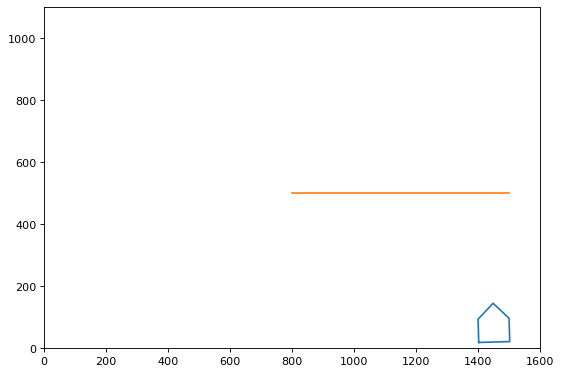

{'x': 1350.898315649373, 'y': 187.66724097339724, 'theta': 2.620819262833761}
0.005008626113671699 0.05008626113671699 8.487916594911802
[198, 209]
346.096900646862
633.2777483430838


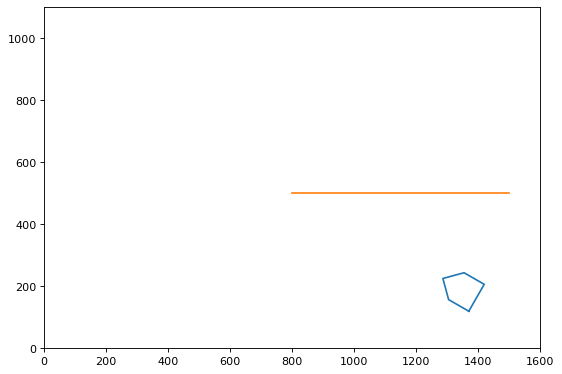

{'x': 1207.8057946736096, 'y': 263.87670023114777, 'theta': 2.674630510472769}
-0.05787992368506245 -0.5787992368506245 7.875558853591832
[187, 180]
375.6749476875614
471.2321920912296


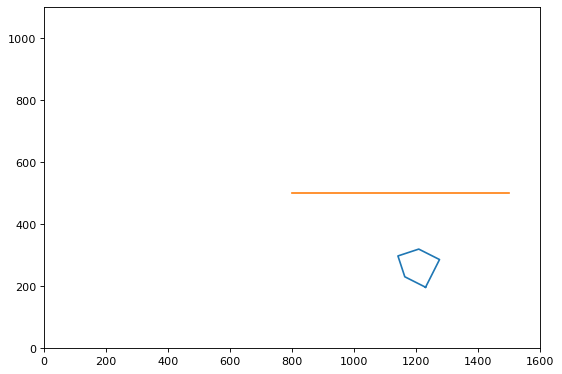

{'x': 1077.5959407374182, 'y': 333.5670164014975, 'theta': 2.60756527919613}
-0.006062071703074601 -0.06062071703074601 7.054645321316278
[162, 168]
454.0100519933519
323.665636642804


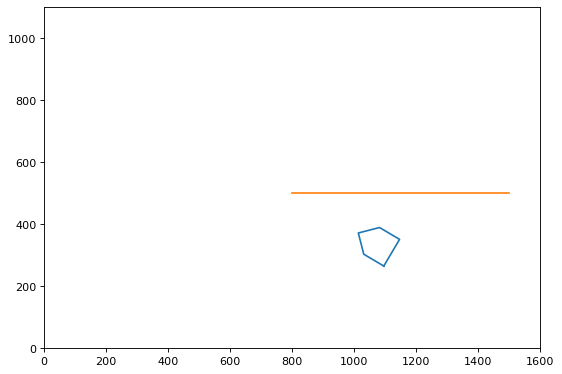

{'x': 961.8000005483198, 'y': 398.0994297530574, 'theta': 2.6355970125904107}
-0.05604318038383482 -0.5604318038383482 6.237380502915258
[153, 144]
547.7617781722641
191.2144513212544


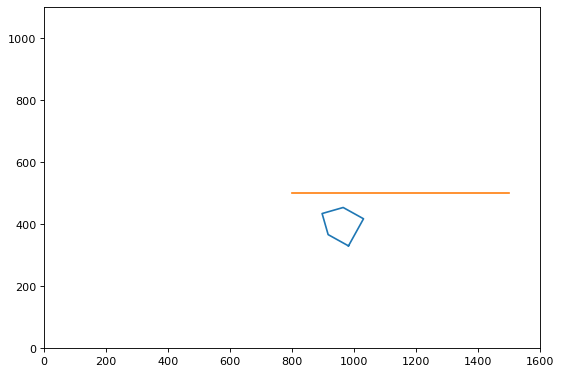

{'x': 860.8345669293683, 'y': 457.9624675861103, 'theta': 2.5795073824580483}
-0.04258427105898521 -0.4258427105898521 5.294901989662119
[137, 131]
640.5463331905171
73.945917162022


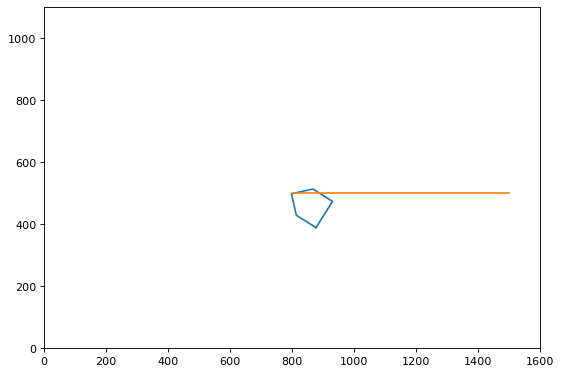

{'x': 785.8089165058695, 'y': 519.9620107705448, 'theta': 1.6447223421546868}
-1.6726655850068197 -16.726655850068195 -11.180548876247661
[300, -30]
714.4700033007148
714.4700033007148


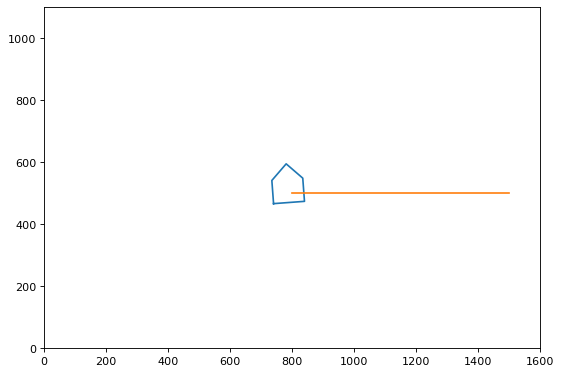

{'x': 908.5095653123158, 'y': 572.7052407904661, 'theta': 6.188720736465236}
-0.027840630779074615 -0.27840630779074615 -22.605755319788756
[216, 182]
595.9420998431184
595.9420998431184


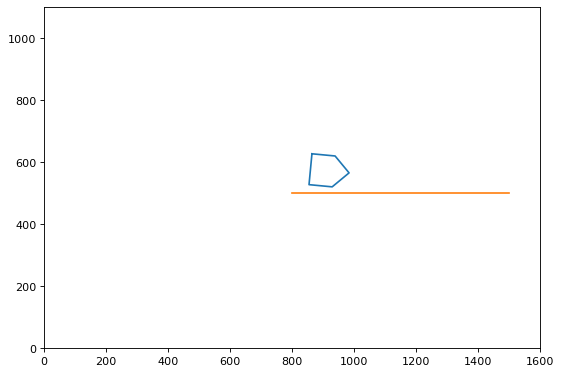

{'x': 1063.0168106481358, 'y': 544.9116216230013, 'theta': 6.049183439160522}
0.13158492532956956 1.3158492532956956 -21.340353867690556
[173, 185]
439.28505726115344
439.28505726115344


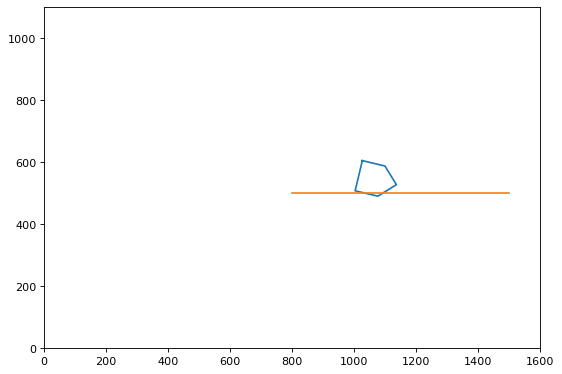

{'x': 1202.8435866846678, 'y': 519.8078397647969, 'theta': 6.109187081965771}
0.10743873141964322 1.0743873141964322 -19.457930484634645
[158, 165]
297.81585668090344
297.81585668090344


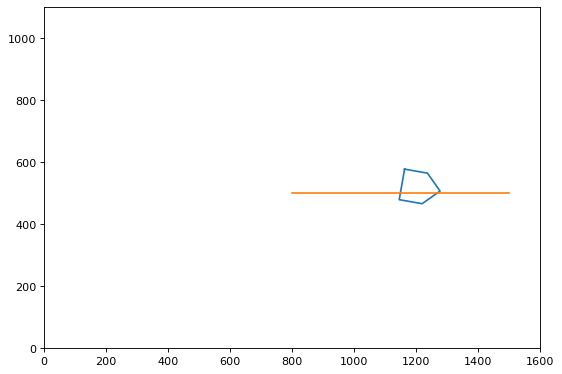

{'x': 1330.018989405781, 'y': 501.75313299913404, 'theta': 6.17753773685008}
0.09533423688523524 0.9533423688523524 -17.449969039522003
[143, 149]
169.99005099694702
169.99005099694702


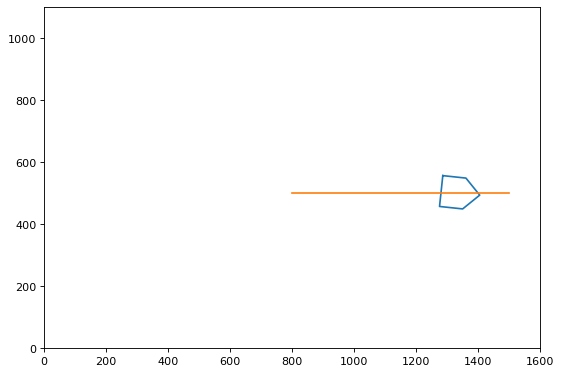

{'x': 1444.1814456351055, 'y': 493.42559779787, 'theta': 6.2564896713385725}
0.14393714566603055 1.4393714566603055 -15.205883418266172
[120, 143]
56.20439285057751
56.20439285057751


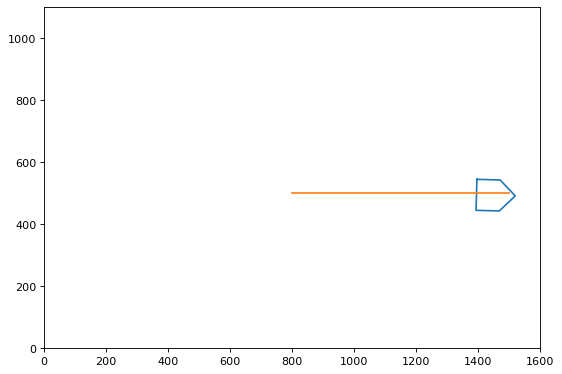

arrive sain et sauf


In [113]:
follow_path([1450,70,math.pi/2],trajnp,True)

In [104]:
motor_left_target=0
motor_right_target=0

In [103]:
5%3

2

array([[1400.,   20.],
       [1500.,   20.],
       [1500.,   95.],
       [1450.,  145.],
       [1400.,   95.],
       [1400.,   20.]])

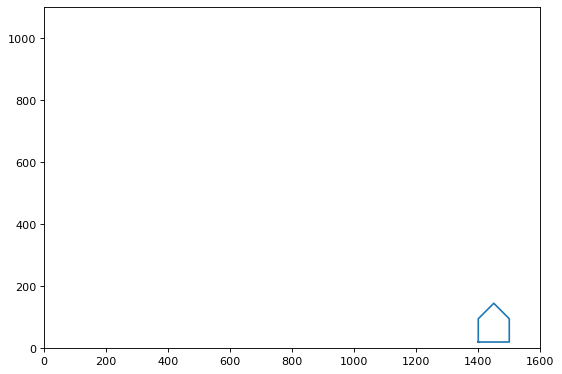

In [109]:
draw_thymio([1450,70,math.pi/2])